# Set Up Env


In [1]:
import sys
import os

import sagemaker
from sagemaker import get_execution_role

# Add the parent directory to the sys.path
sys.path.insert(0, os.path.abspath(".."))

# Define IAM role
role = get_execution_role()
role

# Establish S3 bucket connection
import boto3

s3 = boto3.client("s3")
bucket = "capstone-bucket-4-friends"

# Take a look at current dir
print(os.getcwd())

from file_utilities import s3_download

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
/home/sagemaker-user/capstone-2024-summer/src/jenna/phase_2


# Import libraries


In [2]:
# standard libraries
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt

!pip install seaborn -q
import seaborn as sns

# Download Data from S3 as needed


In [3]:
# link = "CRSP/link_crsp_and_comp_2018-2023.csv"
# link_path = s3_download(link)

In [3]:
# index = "Index/security_master.csv"
# index_path = s3_download(index)

# Load the dataset

https://www.crsp.org/wp-content/uploads/guides/CRSP_US_Stock_&_Indexes_Database_Data_Descriptions_Guide.pdf


In [8]:
link_df = pd.read_csv(
    "/home/sagemaker-user/capstone-2024-summer/data/link_crsp_and_comp_2018-2023.csv",
    parse_dates=["LINKDT"],
    low_memory=False,
)

link_df.head()

,GVKEY,LINKPRIM,LIID,LINKTYPE,LPERMNO,LPERMCO,LINKDT,LINKENDDT,stype,sid,...,snms,soptp1,soptp2,conm,tic,cusip,cik,sic,naics,gsubind
0,1004,P,1,LU,54594,20000,1972-04-24,E,BUSSEG,22,...,Expeditionary Services,PD_SRVC,NaN,AAR CORP,AIR,000361105,1750.0,5080,423860,20101010.0
1,1004,P,1,LU,54594,20000,1972-04-24,E,GEOSEG,5,...,Europe/Africa,GEO,NaN,AAR CORP,AIR,000361105,1750.0,5080,423860,20101010.0
2,1004,P,1,LU,54594,20000,1972-04-24,E,GEOSEG,4,...,North America,GEO,NaN,AAR CORP,AIR,000361105,1750.0,5080,423860,20101010.0
3,1004,P,1,LU,54594,20000,1972-04-24,E,BUSSEG,11,...,Corporate,PD_SRVC,NaN,AAR CORP,AIR,000361105,1750.0,5080,423860,20101010.0
4,1004,P,1,LU,54594,20000,1972-04-24,E,GEOSEG,3,...,Other,GEO,NaN,AAR CORP,AIR,000361105,1750.0,5080,423860,20101010.0


# Take a look at the columns


In [9]:
link_df.columns

Index(['GVKEY', 'LINKPRIM', 'LIID', 'LINKTYPE', 'LPERMNO', 'LPERMCO', 'LINKDT',
       'LINKENDDT', 'stype', 'sid', 'atlls', 'capxs', 'capxs_fn', 'caxts',
       'cogss', 'dps', 'emps', 'emps_fn', 'esubs', 'esubs_fn', 'ias', 'ibs',
       'iints', 'intseg', 'ivaeqs', 'nis', 'nopxs', 'nxints', 'obs', 'ocaxs',
       'oelim', 'oiadps', 'oibdps', 'ops', 'ops_fn', 'ppents', 'ptis', 'rds',
       'rds_fn', 'revts', 'sales', 'sales_fn', 'salexg', 'spis', 'txts',
       'txws', 'xidos', 'xints', 'xsgas', 'datadate', 'srcdate', 'curcds',
       'isosrc', 'naicsh', 'srcs', 'upds', 'NAICSS1', 'NAICSS2', 'SICS1',
       'SICS2', 'geotp', 'snms', 'soptp1', 'soptp2', 'conm', 'tic', 'cusip',
       'cik', 'sic', 'naics', 'gsubind'],
      dtype='object')

In [12]:
link_df.dtypes

GVKEY         int64
LINKPRIM     object
LIID          int64
LINKTYPE     object
LPERMNO       int64
             ...   
cusip        object
cik         float64
sic           int64
naics         int64
gsubind     float64
Length: 71, dtype: object

In [14]:
og_link_len = len(link_df)
og_link_cols = len(link_df.columns)
print("number of records:", og_link_len)
print("number of columns:", og_link_cols)

number of records: 315578
number of columns: 71


# If price is negative, change to NaN to impute

If the closing price is not available on any given trading day, the number in the price field has a negative sign to indicate that it is a bid/ask average and not an actual closing price. Please note that in this field the negative sign is a symbol and that the value of the bid/ask average is not negative.

In [9]:
# crsp_df["PRC"] = crsp_df["PRC"].mask(crsp_df["PRC"] < 0, np.nan)

# Null analysis


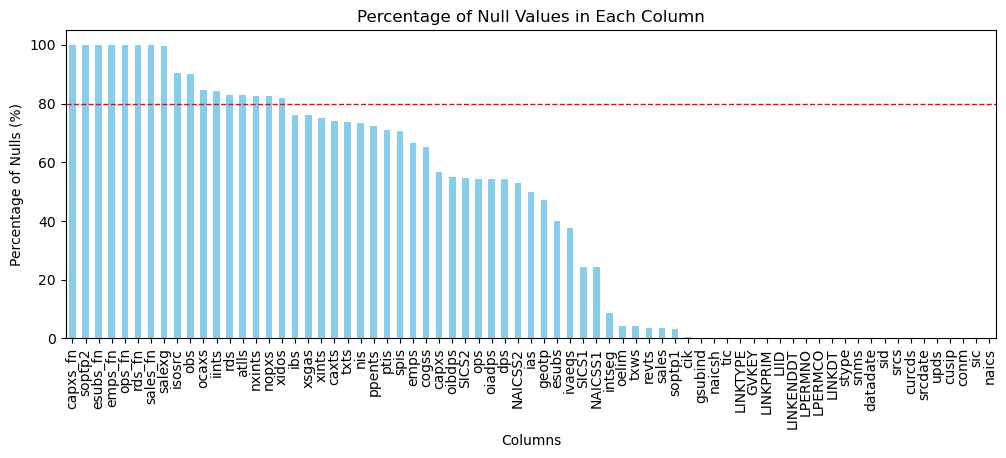

In [22]:
# Count the number of nulls in each column
null_counts = link_df.isnull().sum()

# Calculate the percentage of nulls in each column
total_rows = len(link_df)
null_percentages = (null_counts / total_rows) * 100
null_percentages = null_percentages.sort_values(ascending=False)

# Plot the percentages as a bar plot
null_percentages.plot(kind="bar", figsize=(12, 4), color="skyblue")
plt.axhline(y=80, color="red", linestyle="--", linewidth=1)
plt.title("Percentage of Null Values in Each Column")
plt.xlabel("Columns")
plt.ylabel("Percentage of Nulls (%)")
plt.show()

## A1. Drop all columns which contains more than 80% null as they cannot be reasonably obtained or imputed.


In [23]:
og_cols = len(link_df.columns)
columns_to_drop = null_percentages[null_percentages > 80].index
link_df = link_df.drop(columns=columns_to_drop)
new_cols = len(link_df.columns)
print("num_columns_removed: ", og_cols - new_cols)
print("num_columns_kept:", new_cols)

num_columns_removed:  17
num_columns_kept: 54


## A2. Drop all columns containing duplicate information


In [28]:
og_cols = len(link_df.columns)
columns_to_drop = [
    "LPERMCO",
    # "ISSUNO",
    # "TSYMBOL",
    # "RETX",
    # "vwretx", # Find equivalents in link df
    # "ewretx",
    # "HEXCD",
    # "SICCD",
    # "HSICCD",
    # "HSICIG",
    # "HSICMG",
]
link_df = link_df.drop(columns=columns_to_drop)
new_cols = len(link_df.columns)
print("num_columns_removed: ", og_cols - new_cols)
print("num_columns_kept:", new_cols)

num_columns_removed:  1
num_columns_kept: 53


# Take another look at the null analysis


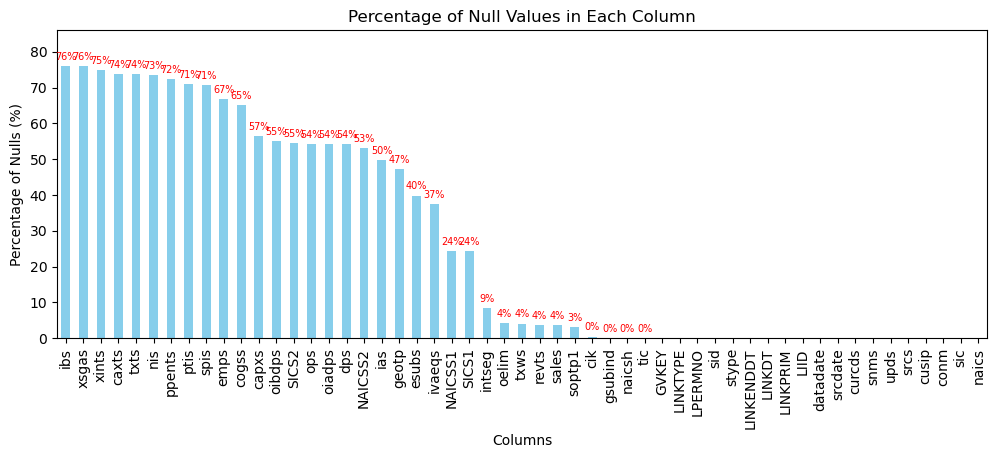

In [32]:
# Count the number of nulls in each column
null_counts = link_df.isnull().sum()

# Calculate the percentage of nulls in each column
total_rows = len(link_df)
null_percentages = (null_counts / total_rows) * 100
null_percentages = null_percentages.sort_values(ascending=False)

# Plot the percentages as a bar plot
ax = null_percentages.plot(kind="bar", figsize=(12, 4), color="skyblue")
plt.title("Percentage of Null Values in Each Column")
plt.xlabel("Columns")
plt.ylim(0, max(null_percentages.values) + 10)
plt.ylabel("Percentage of Nulls (%)")

# Annotate the bars with the percentage values
for i, percentage in enumerate(null_percentages):
    if percentage != 0:
        ax.annotate(
            f"{percentage:.0f}%",
            xy=(i, percentage),
            xytext=(0, 3),
            textcoords="offset points",
            ha="center",
            va="bottom",
            color="red",
            fontsize=7,
        )

plt.show()

# Review unique values and distribution in each remaining column


In [33]:
for column in link_df.columns:
    print("-" * 10, column, "-" * 10)
    print(link_df[column].nunique())
    print(link_df[column].value_counts())

---------- GVKEY ----------
6706
GVKEY
65248     612
160549    585
24724     522
18626     461
4497      439
         ... 
32355       1
32378       1
32450       1
349337      1
36850       1
Name: count, Length: 6706, dtype: int64
---------- LINKPRIM ----------
4
LINKPRIM
P    294846
C     15068
J      5302
N       362
Name: count, dtype: int64
---------- LIID ----------
21
LIID
1     257175
90     31858
2      15063
3       4428
91      2715
4       1379
5        994
92       347
93       274
96       260
6        250
7        174
8        170
99       147
19       120
10        93
9         72
12        30
11        12
21        12
94         5
Name: count, dtype: int64
---------- LINKTYPE ----------
2
LINKTYPE
LC    228847
LU     86731
Name: count, dtype: int64
---------- LPERMNO ----------
6663
LPERMNO
85261    612
14785    461
33823    439
86111    431
91607    416
        ... 
13896      1
23068      1
24017      1
22596      1
23105      1
Name: count, Length: 6663, dtype: int

# Review SHRCD: security type

SHRCD is a two-digit code describing the type of shares traded. The first digit describes the type of security traded.


## B1. Fill SHRCD na with 00 as undefined


In [15]:
# crsp_df["SHRCD"] = crsp_df["SHRCD"].fillna("00")

## B2. Split SHRCD to two columns [SHRCD_Type, SHRCD_Detail]


In [16]:
# crsp_df[["SHRCD_Type", "SHRCD_Detail"]] = crsp_df["SHRCD"].astype(str).str.split("", expand=True).iloc[:, 1:3]

In [17]:
# for column in ["SHRCD_Type", "SHRCD_Detail"]:
#     print("-" * 10, column, "-" * 10)
#     print(crsp_df[column].nunique())
#     print(crsp_df[column].value_counts())

---------- SHRCD_Type ----------
6
SHRCD_Type
1    7720749
7    3858993
3     603387
4     481129
2        764
0        480
Name: count, dtype: int64
---------- SHRCD_Detail ----------
7
SHRCD_Detail
1    6678624
3    3673436
2    1162550
4     817321
8     325543
5       7546
0        482
Name: count, dtype: int64


## B3. Keep only records where SHRCD_type == 1 (Ordinary Common Shares)


In [18]:
# og_len = len(crsp_df)
# crsp_df = crsp_df[crsp_df["SHRCD_Type"] == "1"].reset_index(drop=True)
# new_len = len(crsp_df)
# print("num_records_removed: ", og_len - new_len)
# print("num_records_kept: ", new_len)

num_records_removed:  4944753
num_records_kept:  7720749


# Review EXCHCD: Listed Exchange

EXCHCD is a code indicating the exchange on which a security is listed.


## C1. Fill EXCHCD na with 0 as "not listed in any exchange"


In [19]:
# crsp_df["EXCHCD"] = pd.to_numeric(crsp_df["EXCHCD"], errors="coerce").fillna(0).astype(int)

## C2. Remove all records where EXCHCD < 0 (Halted, Suspended, or Not Trading)


In [20]:
# og_len = len(crsp_df)
# crsp_df = crsp_df[crsp_df["EXCHCD"] > 0].reset_index(drop=True)
# new_len = len(crsp_df)
# print("num_records_removed: ", og_len - new_len)
# print("num_records_kept: ", new_len)

# crsp_df["EXCHCD"] = crsp_df["EXCHCD"].astype(str)

num_records_removed:  41551
num_records_kept:  7679198


# Review PRIMEXCH: Primary Exchange

Primary Exchange is a one-character code which identifies the primary exchange on which the security trades.

https://www.crsp.org/wp-content/uploads/appendix/FlagType_EC.html


## D1. Fill PRIMEXCH na with X as "Unknown"


In [21]:
# crsp_df["PRIMEXCH"] = crsp_df["PRIMEXCH"].fillna("X")

# Review TRDSTAT: Trading Status

Trading Status is a one-character field containing the trading status of securities.


## E1. Fill TRDSTAT na with X as "Unknown"


In [22]:
# crsp_df["TRDSTAT"] = crsp_df["TRDSTAT"].fillna("X")

## E2. Keep only records where TRDSTAT == A (Active trading status)


In [23]:
# og_len = len(crsp_df)
# crsp_df = crsp_df[crsp_df["TRDSTAT"] == "A"].reset_index(drop=True)
# new_len = len(crsp_df)
# print("num_records_removed: ", og_len - new_len)
# print("num_records_kept: ", new_len)

num_records_removed:  0
num_records_kept:  7679198


# Review SECSTAT: Security Status

Security Status is a one-character code that describes the status of a security.


## E1. Fill SECSTAT na with X as "Unknown"


In [24]:
# crsp_df["SECSTAT"] = crsp_df["SECSTAT"].fillna("X")

## E2. Keep only records where SECSTAT == R (Regular Way)


In [25]:
# og_len = len(crsp_df)
# crsp_df = crsp_df[crsp_df["SECSTAT"] == "R"].reset_index(drop=True)
# new_len = len(crsp_df)
# print("num_records_removed: ", og_len - new_len)
# print("num_records_kept: ", new_len)

num_records_removed:  0
num_records_kept:  7679198


# Take another look at the null analysis


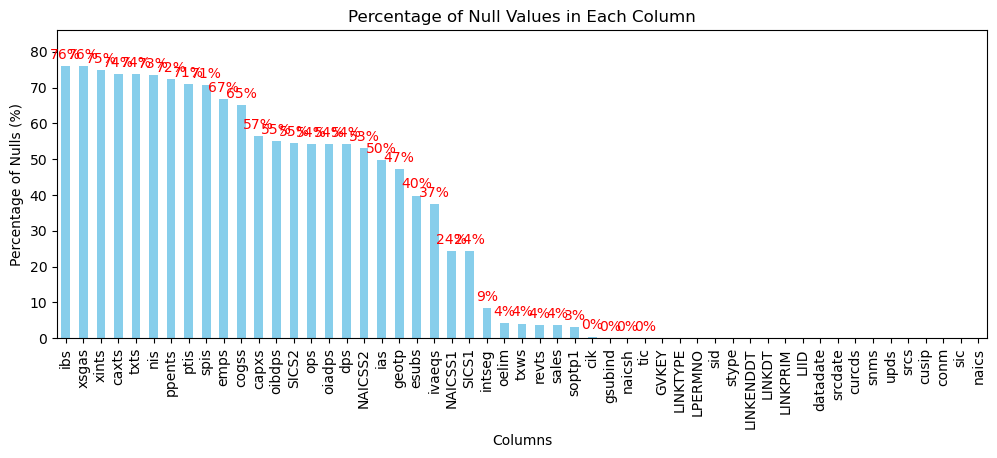

In [35]:
# Count the number of nulls in each column
null_counts = link_df.isnull().sum()

# Calculate the percentage of nulls in each column
total_rows = len(link_df)
null_percentages = (null_counts / total_rows) * 100
null_percentages = null_percentages.sort_values(ascending=False)

# Plot the percentages as a bar plot
ax = null_percentages.plot(kind="bar", figsize=(12, 4), color="skyblue")
plt.title("Percentage of Null Values in Each Column")
plt.xlabel("Columns")
plt.ylim(0, max(null_percentages.values) + 10)
plt.ylabel("Percentage of Nulls (%)")

# Annotate the bars with the percentage values
for i, percentage in enumerate(null_percentages):
    if percentage != 0:
        ax.annotate(
            f"{percentage:.0f}%",
            xy=(i, percentage),
            xytext=(0, 3),
            textcoords="offset points",
            ha="center",
            va="bottom",
            color="red",
        )

plt.show()

# Review NAICS: North American Industry Classification System Code

North American Industry Classification System Code (NAICS) is an 6-character code used to group companies with similar products or services.

NAICS is a hierachical code, containing up to six digits: The first two fields, NAICS sectors, designate general categories of economic activity, the third field, sub-sector, further defines the sector, the fourth field is the industry group, the fifth field is the NAICS industry, and the sixth field represents the national industry (a zero in the 6th digit generally indicates that the NAICS industry and teh country industry are the same).


## F1. Fill NAICS na with 999999 as "Unknown"


In [27]:
link_df["naics"] = link_df["naics"].fillna("999999")

## F2. Split NAICS to two columns ['NAICS_Sector', 'NAICS_Secondary']


In [37]:
link_df["NAICS_Sector"] = link_df["naics"].astype(str).str[:2]
link_df["NAICS_Secondary"] = link_df["naics"].astype(str).str[2:]

In [38]:
for column in ["NAICS_Sector", "NAICS_Secondary"]:
    print("-" * 10, column, "-" * 10)
    print(link_df[column].nunique())
    print(link_df[column].value_counts())

---------- NAICS_Sector ----------
23
NAICS_Sector
33    82579
32    42605
52    41603
51    34902
21    17877
53    14561
31    11339
54    10189
42     8388
48     7430
22     7088
56     6218
45     5512
23     5108
72     4566
44     3384
62     3342
61     2734
99     2108
71     1886
11     1080
81      573
49      506
Name: count, dtype: int64
---------- NAICS_Secondary ----------
512
NAICS_Secondary
2110    18025
5414    12686
8210    10160
4413     9439
1120     8934
        ...  
229         3
35          3
1419        3
1940        2
999         1
Name: count, Length: 512, dtype: int64


## F3. Clean-up the NAICS sector column to readable format

https://www.census.gov/naics/reference_files_tools/2022_NAICS_Manual.pdf


In [40]:
sector_dict = {
    "10": "Metal Mining",
    "11": "Agriculture, Forestry, Fishing and Hunting",
    "21": "Mining, Quarrying, and Oil and Gas Extraction",
    "22": "Utilities",
    "23": "Construction",
    "31": "Manufacturing",
    "32": "Manufacturing",
    "33": "Manufacturing",
    "42": "Wholesale Trade",
    "44": "Retail Trade",
    "45": "Retail Trade",
    "48": "Transportation and Warehousing",
    "49": "Transportation and Warehousing",
    "51": "Information",
    "52": "Finance and Insurance",
    "53": "Real Estate and Rental and Leasing",
    "54": "Professional, Scientific, and Technical Services",
    "55": "Management of Companies and Enterprises",
    "56": "Administrative and Support and Waste Management and Remediation Services",
    "61": "Educational Services",
    "62": "Health Care and Social Assistance",
    "67": "Holding And Other Investment Offices",
    "71": "Arts, Entertainment, and Recreation",
    "72": "Accommodation and Food Services",
    "73": "Business Services",
    "81": "Other Services (except Public Administration)",
    "92": "Public Administration",
    "99": "Unknown",
}

link_df["NAICS_Sector_Name"] = link_df["NAICS_Sector"].replace(sector_dict)

In [43]:
print(link_df["NAICS_Sector_Name"].value_counts())

NAICS_Sector_Name
Manufacturing                                                               136523
Finance and Insurance                                                        41603
Information                                                                  34902
Mining, Quarrying, and Oil and Gas Extraction                                17877
Real Estate and Rental and Leasing                                           14561
Professional, Scientific, and Technical Services                             10189
Retail Trade                                                                  8896
Wholesale Trade                                                               8388
Transportation and Warehousing                                                7936
Utilities                                                                     7088
Administrative and Support and Waste Management and Remediation Services      6218
Construction                                                         

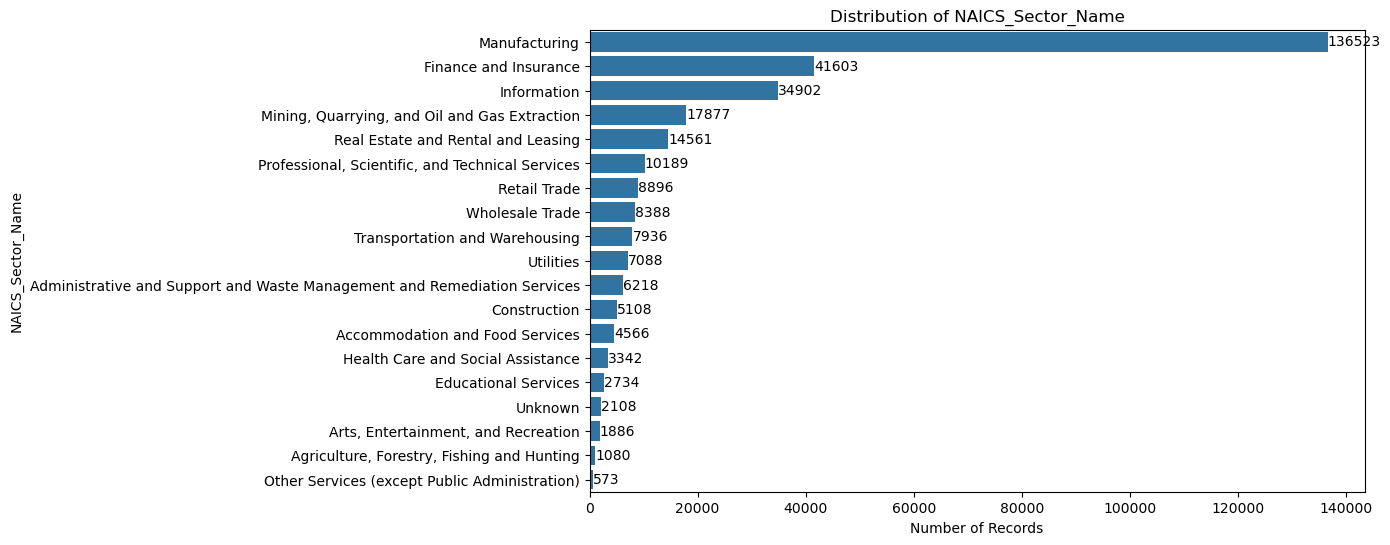

In [45]:
# Calculate the category counts and sort them in descending order
category_counts = link_df["NAICS_Sector_Name"].value_counts().sort_values(ascending=False)

# Plot the counts distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=link_df, y="NAICS_Sector_Name", order=category_counts.index)
plt.title("Distribution of NAICS_Sector_Name")
plt.xlabel("Number of Records")
plt.ylabel("NAICS_Sector_Name")

# Annotate the bars with the count values
for i, count in enumerate(category_counts):
    plt.text(count, i, f"{count}", ha="left", va="center", color="black")

plt.show()

# Review NUMTRD: Number of Trades

Daily: Number of Trades, Nasdaq contains the number of trades made on the Nasdaq Stock Market each date for a security. Trades on all exchanges are connected to Nasdaqs composite pricing network and all paper trades are included in the count. If the number of trades is unavailable, the field is set to 99.


## G1. Fill NUMTRD na with 99 as "Unknown"


In [33]:
# crsp_df["NUMTRD"] = crsp_df["NUMTRD"].fillna("99")

# Review all remaining value related columns.


## H1. Drop all LPERMNO with less than 128 days of return

In [47]:
og_permno = link_df["LPERMNO"].nunique()
permno_counts = link_df["LPERMNO"].value_counts()
permno_to_keep = permno_counts[permno_counts >= 128].index
link_df = link_df[link_df["LPERMNO"].isin(permno_to_keep)].reset_index(drop=True)

assert link_df["LPERMNO"].value_counts().min() >= 128

new_permno = link_df["LPERMNO"].nunique()
print("num_PERMNO_og: ", og_permno)
print("num_PERMNO_removed: ", og_permno - new_permno)
print("num_PERMNO_kept: ", new_permno)

num_PERMNO_og:  465
num_PERMNO_removed:  0
num_PERMNO_kept:  465


## H2. Forward fill trading values

In [48]:
fill_cols = [
    # Previous Variables
    "askhi",
    "ask",
    "bidlo",
    "bid",
    "openprc",
    "prc",
    "ret",
    "cfacpr",
    "cfacshr",
    "vwretd",
    "ewretd",
    "sprtrn",
]
link_df[fill_cols] = link_df[fill_cols].apply(lambda x: pd.to_numeric(x, errors="coerce"))

KeyError: "None of [Index(['askhi', 'ask', 'bidlo', 'bid', 'openprc', 'prc', 'ret', 'cfacpr',\n       'cfacshr', 'vwretd', 'ewretd', 'sprtrn'],\n      dtype='object')] are in the [columns]"

In [49]:
print("before forward fill")
for col in fill_cols:
    print(f"number of nulls in column {col}: ", len(link_df[link_df[col].isnull()]))

before forward fill


KeyError: 'askhi'

In [37]:
# pick an example for visual inspection
review_idx = crsp_df[crsp_df["PRC"].isnull()].index[0]
crsp_df[crsp_df["PRC"].isnull()].iloc[0]

PERMNO                               10028
date                   2018-08-30 00:00:00
SHRCD                                 11.0
EXCHCD                                   2
NCUSIP                            23323G10
TICKER                                DGSE
COMNAM               D G S E COMPANIES INC
NAICS                             448310.0
PRIMEXCH                                 A
TRDSTAT                                  A
SECSTAT                                  R
CUSIP                             29402E10
BIDLO                               0.6897
ASKHI                                  0.7
PRC                                    NaN
VOL                                    0.0
RET                               0.022891
BID                                 0.6897
ASK                                    0.7
SHROUT                             26924.0
CFACPR                                 1.0
CFACSHR                                1.0
OPENPRC                                NaN
NUMTRD     

In [38]:
# forward fill
for col in fill_cols:
    crsp_df[col] = crsp_df.groupby("PERMNO")[col].ffill()

In [39]:
# visually inspect the example to ensure the price was forward filled correctly
crsp_df.iloc[review_idx - 1 : review_idx + 1]["PRC"]

1675    0.6793
1676    0.6793
Name: PRC, dtype: float64

In [40]:
print("after forward fill")
for col in fill_cols:
    print(f"number of nulls in column {col}: ", len(crsp_df[crsp_df[col].isnull()]))

after forward fill
number of nulls in column VOL:  134
number of nulls in column SHROUT:  0
number of nulls in column ASKHI:  135
number of nulls in column ASK:  141
number of nulls in column BIDLO:  135
number of nulls in column BID:  140
number of nulls in column OPENPRC:  2099
number of nulls in column PRC:  2099
number of nulls in column CFACPR:  0
number of nulls in column CFACSHR:  0
number of nulls in column vwretd:  0
number of nulls in column ewretd:  0
number of nulls in column sprtrn:  0


## H3. If PRC is still NaN, that means it was the first day the stock was listed on the exchange, drop these records since we cannot calculate the return for these days

In [41]:
crsp_df.dropna(subset=["PRC"], inplace=True)
crsp_df.reset_index(drop=True, inplace=True)

In [42]:
print("after forward fill")
for col in fill_cols:
    print(f"number of nulls in column {col}: ", len(crsp_df[crsp_df[col].isnull()]))

after forward fill
number of nulls in column VOL:  0
number of nulls in column SHROUT:  0
number of nulls in column ASKHI:  0
number of nulls in column ASK:  6
number of nulls in column BIDLO:  0
number of nulls in column BID:  6
number of nulls in column OPENPRC:  0
number of nulls in column PRC:  0
number of nulls in column CFACPR:  0
number of nulls in column CFACSHR:  0
number of nulls in column vwretd:  0
number of nulls in column ewretd:  0
number of nulls in column sprtrn:  0


## H4. If ASK, BID, OPENPRC are still NaN, fill them with 0

In [43]:
crsp_df["ASK"] = crsp_df["ASK"].fillna(0)
crsp_df["BID"] = crsp_df["BID"].fillna(0)
crsp_df["OPENPRC"] = crsp_df["OPENPRC"].fillna(0)

In [44]:
print("confirm forward fill was complete")
for col in fill_cols:
    assert len(crsp_df[crsp_df[col].isnull()]) == 0

confirm forward fill was complete


## H5. If RET is NaN, calculate the RET based on forward filled PRICE

In [45]:
crsp_df["RET"] = pd.to_numeric(crsp_df["RET"], errors="coerce")
print(f"number of nulls in column RET: ", len(crsp_df[crsp_df["RET"].isnull()]))

number of nulls in column RET:  4334


In [46]:
# pick an example for visual inspection
review_idx = crsp_df[crsp_df["RET"].isnull()].index[1]
crsp_df[crsp_df["RET"].isnull()].iloc[1]

PERMNO                                           10051
date                               2022-10-04 00:00:00
SHRCD                                             11.0
EXCHCD                                               1
NCUSIP                                        41043F20
TICKER                                            HNGR
COMNAM                                      HANGER INC
NAICS                                         621498.0
PRIMEXCH                                             N
TRDSTAT                                              A
SECSTAT                                              R
CUSIP                                         41043F20
BIDLO                                              5.0
ASKHI                                            19.73
PRC                                              18.72
VOL                                                0.0
RET                                                NaN
BID                                                5.0
ASK       

In [47]:
# Calculate previous day's price for each PERMNO
crsp_df["prev_price"] = crsp_df.groupby("PERMNO")["PRC"].shift(1)

# Fill NaN values in the return column
crsp_df["RET"] = crsp_df.apply(
    lambda row: (row["PRC"] / row["prev_price"] - 1) if pd.isnull(row["RET"]) else row["RET"], axis=1
)

In [48]:
# visually inspect the example to ensure the return was calculated correctly
display(crsp_df.iloc[review_idx - 1 : review_idx + 1]["PERMNO"])
display(crsp_df.iloc[review_idx - 1 : review_idx + 1]["PRC"])
display(crsp_df.iloc[review_idx - 1 : review_idx + 1]["prev_price"])
display(crsp_df.iloc[review_idx - 1 : review_idx + 1]["RET"])

crsp_df.drop(columns=["prev_price"], inplace=True)

7057    10051
7058    10051
Name: PERMNO, dtype: int64

7057    18.72
7058    18.72
Name: PRC, dtype: float64

7057    18.72
7058    18.72
Name: prev_price, dtype: float64

7057   -0.339476
7058    0.000000
Name: RET, dtype: float64

## H6. If RET is still NaN, that means the previous price is not in this subset of the dataset, fill RET with 0

In [49]:
print(f"number of nulls in column RET: ", len(crsp_df[crsp_df["RET"].isnull()]))

number of nulls in column RET:  2276


In [50]:
crsp_df["RET"] = crsp_df["RET"].fillna(0)

In [51]:
assert len(crsp_df[crsp_df["RET"].isnull()]) == 0

## H7. Cast to appropriate type

In [52]:
int_cols = ["VOL", "SHROUT", "NUMTRD"]
float_cols = [
    "ASKHI",
    "ASK",
    "BIDLO",
    "BID",
    "OPENPRC",
    "PRC",
    "RET",
    "CFACPR",
    "CFACSHR",
    "vwretd",
    "ewretd",
    "sprtrn",
]
str_cols = [
    "PERMNO",
    "NCUSIP",
    "CUSIP",
    "TICKER",
    "SHRCD",
    "SHRCD_Type",
    "SHRCD_Detail",
    "EXCHCD",
    "COMNAM",
    "PRIMEXCH",
    "TRDSTAT",
    "SECSTAT",
    "NAICS",
    "NAICS_Sector",
    "NAICS_Secondary",
]

In [53]:
crsp_df[int_cols] = crsp_df[int_cols].astype(int)
crsp_df[float_cols] = crsp_df[float_cols].astype(float)
crsp_df[str_cols] = crsp_df[str_cols].astype(str)

## H8. Remove outliers, PERMNO that had more than 10 days of over 100% or under -50% returns

Return is calculated using (close_price/previous_close_price)-1.

In [54]:
# Define the conditions
over_100_percent = crsp_df["RET"] > 1.0
under_50_percent = crsp_df["RET"] < -0.5

# Create a boolean mask for the conditions
condition_mask = over_100_percent | under_50_percent

# Count the number of days each permno_id satisfies the condition
permno_counts = crsp_df[condition_mask].groupby("PERMNO").size()

In [55]:
# Filter out PERMNO with more than 10 days satisfying the condition
to_remove = permno_counts[permno_counts > 10].index
print("num_PERMNO_removed: ", len(to_remove))

# Filter the DataFrame to exclude those PERMNO
og_len = len(crsp_df)
crsp_df = crsp_df[~crsp_df["PERMNO"].isin(to_remove)]
new_len = len(crsp_df)
print("num_records_removed: ", og_len - new_len)
print("num_records_kept: ", new_len)

num_PERMNO_removed:  1
num_records_removed:  1503
num_records_kept:  7658080


# Take another look at the null analysis


In [56]:
# Count the number of nulls in each column
null_counts = crsp_df.isnull().sum()

# Calculate the percentage of nulls in each column
total_rows = len(crsp_df)
null_percentages = (null_counts / total_rows) * 100

assert null_percentages.min() == 0.0

## I1. Remove duplicates


In [57]:
og_len = len(crsp_df)
crsp_df = crsp_df.drop_duplicates()
new_len = len(crsp_df)
print("num_records_removed: ", og_len - new_len)
print("num_records_kept: ", new_len)

num_records_removed:  1124
num_records_kept:  7656956


## I2. Confirm each PERMNO contains at most num_days records (each PERMNO only has one record per day)


In [58]:
num_days = crsp_df["date"].nunique()

In [59]:
assert crsp_df["PERMNO"].value_counts().max() <= num_days

## I3. Rename & Reorder all columns


In [60]:
rename_dict = {
    "date": "date",
    "PERMNO": "permno_id",
    "NCUSIP": "ncusip_id",
    "CUSIP": "cusip_id",
    "TICKER": "ticker",
    "SHRCD": "share_code",
    "SHRCD_Type": "share_code_type",
    "SHRCD_Detail": "share_code_detail",
    "EXCHCD": "exchange_code",
    "COMNAM": "company_name",
    "PRIMEXCH": "primary_exchange",
    "TRDSTAT": "trading_status",
    "SECSTAT": "security_status",
    "NAICS": "naics",
    "NAICS_Sector": "naics_sector",
    "NAICS_Sector_Name": "naics_sector_name",
    "NAICS_Secondary": "naics_secondary",
    "ASKHI": "ask_or_high_price",
    "ASK": "ask_price",
    "BIDLO": "bid_or_low_price",
    "BID": "bid_price",
    "OPENPRC": "open_price",
    "PRC": "close_price",
    "RET": "return",
    "VOL": "volume",
    "SHROUT": "shares_outstanding",
    "NUMTRD": "num_trades",
    "CFACPR": "factor_to_adjust_price",
    "CFACSHR": "factor_to_adjust_shares",
    "vwretd": "value_weighted_return",
    "ewretd": "equal_weighted_return",
    "sprtrn": "return_on_SP_index",
}

crsp_df = crsp_df.rename(columns=rename_dict)
crsp_df = crsp_df[list(rename_dict.values())]

# Take a final look at the columns


In [61]:
crsp_df.columns

Index(['date', 'permno_id', 'ncusip_id', 'cusip_id', 'ticker', 'share_code',
       'share_code_type', 'share_code_detail', 'exchange_code', 'company_name',
       'primary_exchange', 'trading_status', 'security_status', 'naics',
       'naics_sector', 'naics_sector_name', 'naics_secondary',
       'ask_or_high_price', 'ask_price', 'bid_or_low_price', 'bid_price',
       'open_price', 'close_price', 'return', 'volume', 'shares_outstanding',
       'num_trades', 'factor_to_adjust_price', 'factor_to_adjust_shares',
       'value_weighted_return', 'equal_weighted_return', 'return_on_SP_index'],
      dtype='object')

In [62]:
crsp_df.dtypes

date                       datetime64[ns]
permno_id                          object
ncusip_id                          object
cusip_id                           object
ticker                             object
share_code                         object
share_code_type                    object
share_code_detail                  object
exchange_code                      object
company_name                       object
primary_exchange                   object
trading_status                     object
security_status                    object
naics                              object
naics_sector                       object
naics_sector_name                  object
naics_secondary                    object
ask_or_high_price                 float64
ask_price                         float64
bid_or_low_price                  float64
bid_price                         float64
open_price                        float64
close_price                       float64
return                            

In [63]:
crsp_len = len(crsp_df)
crsp_cols = len(crsp_df.columns)
print("number of records:", crsp_len)
print("number of columns:", crsp_cols)

number of records: 7656956
number of columns: 32


# Review unique values and distribution in each remaining column


In [64]:
for column in crsp_df.columns:
    print("-" * 10, column, "-" * 10)
    print(crsp_df[column].nunique())
    print(crsp_df[column].value_counts())

---------- date ----------
1509
date
2022-05-18    5890
2022-05-17    5890
2022-05-19    5889
2022-05-13    5889
2022-05-16    5888
              ... 
2018-01-08    4422
2018-01-05    4419
2018-01-04    4415
2018-01-03    4408
2018-01-02    4395
Name: count, Length: 1509, dtype: int64
---------- permno_id ----------
7145
permno_id
93436    1509
10026    1509
10028    1509
10032    1509
10044    1509
         ... 
24009     129
23970     128
23994     128
23978     128
89681     127
Name: count, Length: 7145, dtype: int64
---------- ncusip_id ----------
9047
ncusip_id
88160R10    1509
46603210    1509
78513510    1509
12503M10    1509
72913210    1509
            ... 
75811Y10       1
74102L20       1
92535P87       1
45784G10       1
05338F30       1
Name: count, Length: 9047, dtype: int64
---------- cusip_id ----------
7147
cusip_id
88160R10      1509
46603210      1509
29402E10      1509
72913210      1509
77467X10      1509
              ... 
G3398L11       128
50012A10       128
80

# Save the cleaned df as csv & parquet


In [65]:
crsp_df.to_csv(
    "/home/sagemaker-user/capstone-2024-summer/data/crsp_2018-2023_clean.csv",
    index=False,
)
crsp_df.to_parquet("/home/sagemaker-user/capstone-2024-summer/data/crsp_2018-2023_clean.parquet")

In [66]:
reload = pd.read_parquet("/home/sagemaker-user/capstone-2024-summer/data/crsp_2018-2023_clean.parquet")
assert crsp_df.equals(reload)

reload.head()

,date,permno_id,ncusip_id,cusip_id,ticker,share_code,share_code_type,share_code_detail,exchange_code,company_name,...,close_price,return,volume,shares_outstanding,num_trades,factor_to_adjust_price,factor_to_adjust_shares,value_weighted_return,equal_weighted_return,return_on_SP_index
0,2018-01-02,10026,46603210,46603210,JJSF,11.0,1,1,3,J & J SNACK FOODS CORP,...,149.17999,-0.017454,190618,18668,1036,1.0,1.0,0.008505,0.011232,0.008303
1,2018-01-03,10026,46603210,46603210,JJSF,11.0,1,1,3,J & J SNACK FOODS CORP,...,147.69000,-0.009988,63693,18668,1283,1.0,1.0,0.005856,0.005103,0.006399
2,2018-01-04,10026,46603210,46603210,JJSF,11.0,1,1,3,J & J SNACK FOODS CORP,...,149.73000,0.013813,127552,18668,1138,1.0,1.0,0.004001,0.005272,0.004029
3,2018-01-05,10026,46603210,46603210,JJSF,11.0,1,1,3,J & J SNACK FOODS CORP,...,148.30000,-0.009550,44647,18668,745,1.0,1.0,0.005804,0.003880,0.007034
4,2018-01-08,10026,46603210,46603210,JJSF,11.0,1,1,3,J & J SNACK FOODS CORP,...,148.41000,0.000742,55014,18668,990,1.0,1.0,0.001816,0.000584,0.001662


# Upload the parquet to s3


In [67]:
s3.upload_file(
    "/home/sagemaker-user/capstone-2024-summer/data/crsp_2018-2023_clean.parquet",
    bucket,
    "CRSP/crsp_2018-2023_clean.parquet",
)

In [68]:
reload_path = s3_download("CRSP/crsp_2018-2023_clean.parquet")

In [69]:
reload = pd.read_parquet("/home/sagemaker-user/capstone-2024-summer/data/crsp_2018-2023_clean.parquet")
assert crsp_df.equals(reload)

reload.head()

,date,permno_id,ncusip_id,cusip_id,ticker,share_code,share_code_type,share_code_detail,exchange_code,company_name,...,close_price,return,volume,shares_outstanding,num_trades,factor_to_adjust_price,factor_to_adjust_shares,value_weighted_return,equal_weighted_return,return_on_SP_index
0,2018-01-02,10026,46603210,46603210,JJSF,11.0,1,1,3,J & J SNACK FOODS CORP,...,149.17999,-0.017454,190618,18668,1036,1.0,1.0,0.008505,0.011232,0.008303
1,2018-01-03,10026,46603210,46603210,JJSF,11.0,1,1,3,J & J SNACK FOODS CORP,...,147.69000,-0.009988,63693,18668,1283,1.0,1.0,0.005856,0.005103,0.006399
2,2018-01-04,10026,46603210,46603210,JJSF,11.0,1,1,3,J & J SNACK FOODS CORP,...,149.73000,0.013813,127552,18668,1138,1.0,1.0,0.004001,0.005272,0.004029
3,2018-01-05,10026,46603210,46603210,JJSF,11.0,1,1,3,J & J SNACK FOODS CORP,...,148.30000,-0.009550,44647,18668,745,1.0,1.0,0.005804,0.003880,0.007034
4,2018-01-08,10026,46603210,46603210,JJSF,11.0,1,1,3,J & J SNACK FOODS CORP,...,148.41000,0.000742,55014,18668,990,1.0,1.0,0.001816,0.000584,0.001662


# Confirm no records of < -1 return

In [70]:
assert len(crsp_df[crsp_df["return"] < -1]) == 0